In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import os
import re
import math
import matplotlib.pyplot as plt

import sys
sys.path.append(r'../')

In [2]:
import gmsh
import pygmsh

from pyhmesh import BackgroundMesh
from pyhmesh import SurfaceMesh

In [229]:
def createModel():
    with pygmsh.occ.Geometry() as geom:
        Domain=geom.add_rectangle([0,0, 0.0], 20.0, 10.0)
        obj1=geom.add_rectangle([6,3, 0.0], 3, 6)
        obj2=geom.add_disk([14,5.0, 0.0],1,1)
        obj3=geom.add_disk([14,8.0, 0.0],1,1)
        obj4=geom.add_disk([14,6.0, 0.0],1,1)

        region=geom.boolean_difference(Domain,[obj1,obj2,obj3,obj4])
        geom.synchronize()

        geom.save_geometry('model_test.step')

In [230]:
createModel()

In [191]:
mesh = SurfaceMesh()
mesh.generate('model_test.step')

nodes,eles_bd = mesh.getMesh()

img, mesh_surf =  mesh.voxlize(dx=mesh.length/200, return_mesh=True)

curvs=mesh.curvature()

mesh.close()

Reading model_test.step...
Model dimension= 2
domain [<pygmsh Dummy object, ID 1>, <pygmsh Dummy object, ID 2>, <pygmsh Dummy object, ID 3>, <pygmsh Dummy object, ID 4>, <pygmsh Dummy object, ID 5>, <pygmsh Dummy object, ID 6>, <pygmsh Dummy object, ID 9>, <pygmsh Dummy object, ID 8>, <pygmsh Dummy object, ID 7>]
boundary [<pygmsh Dummy object, ID 1>, <pygmsh Dummy object, ID 2>, <pygmsh Dummy object, ID 3>, <pygmsh Dummy object, ID 4>, <pygmsh Dummy object, ID 5>, <pygmsh Dummy object, ID 6>, <pygmsh Dummy object, ID 9>, <pygmsh Dummy object, ID 8>, <pygmsh Dummy object, ID 7>]
Get nodes from 9 boundary entites
Get eles from 9 boundary entites
uint64 int64 246
Get nodes from 11 boundary entites
Get eles from 11 boundary entites
uint64 int64 5068
Image Origin= [0.0, 0.0, -0.100000001]
Image Shape= [200 100   1]
Image Extent= [  0 199   0  99   0   0]


In [201]:
transform_matrix = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 10, 0],
                             [0, 0, 0, 1]])

mesh_scale = mesh_surf.transform(transform_matrix, inplace=False)
mesh_scale

PolyData,Information
N Cells,10140
N Points,5068
X Bounds,"0.000e+00, 2.000e+01"
Y Bounds,"0.000e+00, 1.000e+01"
Z Bounds,"-1.000e+00, 0.000e+00"
N Arrays,0


In [202]:
pcd = pv.PolyData(mesh_scale.points)
pcd.save(r"F:\Point2Skeleton\data\pointclouds\test\test.ply",binary=False)

In [ ]:
pv.save_meshio()

In [193]:
import pyvista as pv
pv.save_meshio(r"C:\Users\PoreSimPC_New\Downloads\Compressed\qmat_x64_runnable\test.off", mesh_scale)

In [189]:
mesh_feature = mesh_surf.compute_normals()
mesh_feature['Curvature']=curvs

In [190]:
mesh_feature.save('test.vtp')

In [187]:
faceTags=[i for i,e in enumerate(eles_bd) for j in range(len(e)) ]
eles = np.vstack(eles_bd)

In [178]:
import matplotlib
from matplotlib.collections import LineCollection,EllipseCollection


def plot_mesh(verts,edges,edge_scalar=None):
    #Plot throat size map
    ax=plt.gca()
    #Color edge by scalar (edge_scalar)
    
    if(edge_scalar is not None): 
        edge_scalar=np.array(edge_scalar)
        
        norm = plt.Normalize(np.min(edge_scalar), np.max(edge_scalar))
        coll = LineCollection(verts[edges,:], cmap='viridis', norm=norm, lw=0.8)
        coll.set_array(edge_scalar)
        lines=ax.add_collection(coll)
        fig.colorbar(lines, orientation='vertical',ax=ax)
    else:
        coll = matplotlib.collections.LineCollection(verts[edges,:], lw=0.8)
        lines=ax.add_collection(coll)
    ax.margins(0.05)

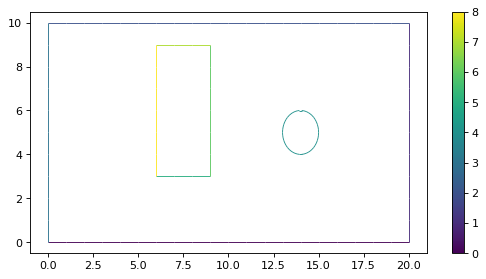

In [179]:
fig=plt.figure(figsize=(8, 4), dpi=80)
plot_mesh(nodes[:,0:2],eles,edge_scalar=faceTags)
plt.show()